In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import os

import json
import pandas as pd

from sqlalchemy.types import TIMESTAMP as typeTIMESTAMP

from dotenv import load_dotenv

load_dotenv(verbose=True)

import math
import logging
logger = logging.getLogger(__name__)

import dateutil

In [2]:
print (os.getcwd())

/Users/shivangi/Documents/Dissertation/power_monitor_analysis


In [3]:
from sqlalchemy import create_engine
REMOTE_HOST=os.getenv('REMOTE_HOST')
REMOTE_DB_PASS=os.getenv('REMOTE_DB_PASS')
REMOTE_USER=os.getenv('REMOTE_USER')
DB_NAME=os.getenv('DB_NAME')

engine = create_engine(f'postgresql+psycopg2://{REMOTE_USER}:{REMOTE_DB_PASS}@{REMOTE_HOST}/{DB_NAME}', server_side_cursors=True)

# 4 Alternatives to read the data
evaluate only one of these, as desired

# read in chunks
for huge data

In [6]:
# https://stackoverflow.com/questions/18107953/how-to-create-a-large-pandas-dataframe-from-an-sql-query-without-running-out-of
def read_db_in_chunks(connection):
    import pandas.io.sql as psql
    chunk_size = 10000
    offset = 0
    dfs = []
    while True:
      sql = """
SELECT
       to_timestamp(event_data::json -> 'new_state' ->> 'last_changed','YYYY-MM-DD"T"HH24:MI:SS.US') as last_changed,
       event_data::json -> 'new_state' -> 'entity_id' as entity_id,
       event_data::json -> 'new_state' -> 'attributes' -> 'node_id' as node_id,
       event_data::json -> 'new_state' -> 'attributes' -> 'power_consumption' as power_consumption,
       event_data::json -> 'new_state' -> 'attributes' -> 'unit_of_measurement' as unit
FROM  events
WHERE event_type like 'state_changed'
AND event_data::json ->> 'entity_id' = 'sensor.aeon_labs_zw096_smart_switch_6_power_2'      
limit %d offset %d""" % (chunk_size,offset)
      dfs.append(psql.read_sql_query(sql, con=connection))
      offset += chunk_size
      if len(dfs[-1]) < chunk_size:
        break
    df = pd.concat(dfs)
    return df

# comment out the below
# df = read_db_in_chunks(engine)
## Read a portion

# Read in one go
set limit as `last_hours`

In [4]:
# table_name='events'

last_hours = 24
df = pd.read_sql_query(f"""
SELECT
       to_timestamp(event_data::json -> 'new_state' ->> 'last_changed','YYYY-MM-DD"T"HH24:MI:SS.US') as last_changed,
       event_data::json -> 'new_state' -> 'entity_id' as entity_id,
       event_data::json -> 'new_state' -> 'attributes' -> 'node_id' as node_id,
       event_data::json -> 'new_state' -> 'attributes' -> 'power_consumption' as power_consumption,
       event_data::json -> 'new_state' -> 'attributes' -> 'unit_of_measurement' as unit
FROM  events
WHERE event_type like 'state_changed'
AND event_data::json ->> 'entity_id' = 'sensor.aeon_labs_zw096_smart_switch_6_power_2'
-- ORDER BY last_changed DESC limit 3600 * {last_hours}
;
""", con=engine)

In [5]:
df['last_changed'] = pd.to_datetime(df['last_changed'], errors='coerce')
df.dropna(subset=['last_changed'], inplace=True)
df.set_index('last_changed', inplace=True)

In [6]:
df

,entity_id,node_id,power_consumption,unit
last_changed,,,,
2020-05-30 14:32:48.779499+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.826,W
2020-05-30 14:32:51.795031+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.551,W
2020-05-30 14:32:54.798765+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.770,W
2020-05-30 14:32:57.793024+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.888,W
2020-05-30 14:33:00.791574+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.677,W
...,...,...,...,...
2020-05-30 14:32:33.790128+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.784,W
2020-05-30 14:32:36.793057+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.675,W
2020-05-30 14:32:39.782380+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,16.729,W


# Read from CSV
when a DB export was made on the command line
`source .env`
`pg_dump -v -h $REMOTE_HOST -Fc -o -U $REMOTE_USER aq > pm_backup_20190713.sql`

In [ ]:
# Read from CSV
file_path = 'pm_backup_20190713.csv'
# 88880001,3,,,Temperature,2019-07-10 09:39:08+00,1562751548000,31.9802398681641

df = pd.read_csv(file_path, names=['last_changed','entity_id','node_id','power_consumption','unit_of_measurement'], header=None)

In [ ]:
df.set_index('timestamp', inplace=True)

In [ ]:
df = df.sort_index()

In [ ]:
df.tail()

# Write to HDF5
to create a backup

In [8]:
from datetime import datetime

_date = datetime.today().strftime('%Y-%m-%d')

In [9]:
df.to_hdf(f'pm_data_{_date}.h5', key='df', mode='w')

/Users/csxds/workspaces/venvs/power_monitor/lib/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['last_changed', 'entity_id', 'unit'], dtype='object')]

  encoding=encoding,


# Read from HDF5
to read a backup

In [10]:
!ls

README.md             pm_data_2020-05-31.h5 requirements.txt
pm_data_2020-05-30.h5 power.pdf             visualise.ipynb


In [12]:
hdf5_file = 'pm_data_2020-05-31.h5'

In [13]:
df = pd.read_hdf(hdf5_file)

In [35]:
df.loc['2020-06-01':'2020-06-01'].between_time('8:00', '8:38')['power_consumption'].min()

0.0

# Now do something with the data

# Plot

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


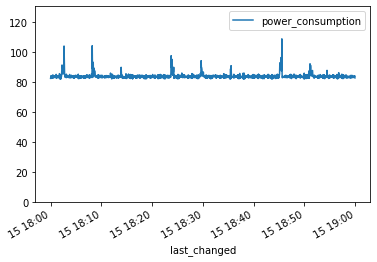

In [10]:
# df_subset = df.loc['2020-06-01':'2020-06-01'].between_time('8:00', '8:38')[['power_consumption']]
# df_subset[(df_subset != 0).all(1)].plot(ylim=(0,df_subset.max()*1.2))
start_date = '2020-06-15'
end_date = '2020-06-15'
start_time = '18:00'
end_time = '19:00'


subset_df = df.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
y_max = subset_df['power_consumption'].max() * 1.2

subset_df[(df != 0).all(1)].plot(ylim=(0,y_max))

In [8]:
subset_df[(df != 0).all(1)].describe()

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,power_consumption
count,6000.000000
mean,83.898179
std,2.325509
min,81.214000
25%,83.044000
50%,83.501000
75%,84.027000
max,111.563000


In [24]:
plt.savefig('power.pdf')

<Figure size 432x288 with 0 Axes>